## Tasks

* Implement vanilla autoencoder
* Train it on MNIST dataset MNIST
* Display digits recovered dy AE
* Display distribution of embeddings in latent space

## Ideas for extra work

* Find the best latent space size
* Implement noise filtration with AE
* Test vector arithmetic in laent space
* Implemet VAE
    * Use Autoencoder class as base class
    * Implement VAE Loss class
    * Plot embeddings manifold in VAE latent space
    * Compare decoding results VAE latent space with vanilla Autoencoder results
* Replace reconstruction loss from MSE to BCE
* Implement Conditional Autoencoder or CVAE

## Imports

In [29]:
import os
import abc
import typing
import random
import warnings

import tqdm
import torch
import wandb
import numpy
import seaborn
import torchvision
import sklearn.manifold
import matplotlib.pyplot as plt
import torchvision.transforms.v2
import torch.utils.data as torchdata

warnings.filterwarnings("ignore")

device = torch.device(
    "cuda" if torch.cuda.is_available()
    else "mps" if torch.backends.mps.is_available()
    else "cpu"
)
print(device)

RANDOM_STATE = 42
def set_random_seed(seed):
    random.seed(seed)
    numpy.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    torch.backends.cudnn.deterministic = True
def fix_random():
    return set_random_seed(RANDOM_STATE)
fix_random()

mps


## Dataset

http://yann.lecun.com/exdb/mnist/

The MNIST database of handwritten digits, has a training set of 60,000 examples, and a test set of 10,000 examples.

The images were centered in a 28x28 image by computing the center of mass of the pixels.

In [30]:
transform = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.Resize((32, 32)), # Added Resize for convenience later
    torchvision.transforms.v2.ToImage(),
    torchvision.transforms.v2.ToDtype(torch.float32, scale = True)
])

def calc_channel_stats(dataset: torchdata.Dataset) -> typing.Tuple[torch.Tensor, torch.Tensor]:
    all_images = torch.stack([ item[0] for item in dataset ])
    mean = torch.mean(all_images, dim = [0, 2, 3])
    std = torch.std(all_images, dim = [0, 2, 3])
    return mean, std

mean, std = calc_channel_stats(torchvision.datasets.MNIST('mnist', train = True, download = True, transform = transform))
print(mean, std)

tensor([0.1309]) tensor([0.2893])


In [31]:
transform = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.Resize((32, 32)),
    torchvision.transforms.v2.ToImage(),
    torchvision.transforms.v2.ToDtype(torch.float32, scale = True),
    torchvision.transforms.v2.Normalize(mean, std)
])

train_ds = torchvision.datasets.MNIST('mnist', train = True, download = True, transform = transform)
test_ds = torchvision.datasets.MNIST('mnist', train = False, download = True, transform = transform)

Display some samples along with corresponding labels

In [32]:
# Denormalization
denormalize = torchvision.transforms.v2.Compose([
    torchvision.transforms.v2.Normalize(mean = torch.zeros_like(mean), std = 1 / std),
    torchvision.transforms.v2.Normalize(mean = -mean, std = torch.ones_like(std))
])

def display_image(image: torch.Tensor, label: str):
    plt.axis('off')
    plt.title('{}'.format(label))
    plt.imshow((torch.clamp(denormalize(image), 0., 1.).permute(1, 2, 0).detach().cpu().numpy() * 255).astype(numpy.uint8), cmap = "gray")

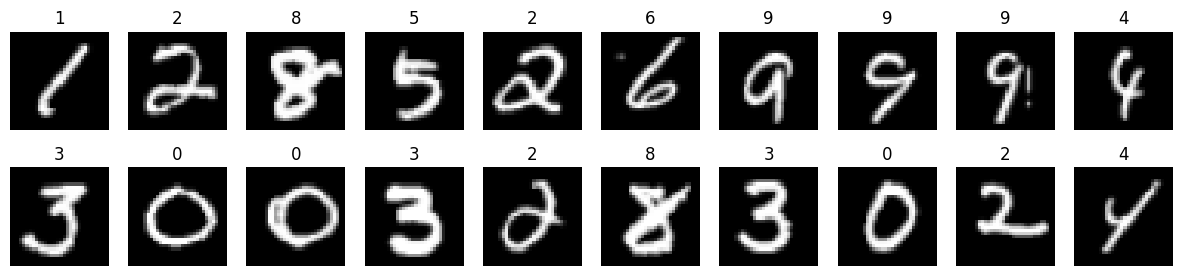

In [33]:
def display_examples(dataset: torchdata.Dataset, row: int):
    train_loader = torchdata.DataLoader(dataset, batch_size = 10, shuffle = True)
    for i, (image, label) in enumerate(zip(*next(iter(train_loader)))):
        plt.subplot(3, 10, i + 10 * (row - 1) + 1)
        display_image(image, label)

# Display some samples from each dataset
fix_random()
plt.rcParams["figure.figsize"] = (15, 5)
display_examples(train_ds, 1)
display_examples(test_ds, 2)

Define dataloaders

In [34]:
train_loader = torchdata.DataLoader(train_ds, shuffle = True, batch_size = 128)
test_loader = torchdata.DataLoader(test_ds, shuffle = False, batch_size = 256)

## Abstract

### Model

In [35]:
class BaseEncoder(torch.nn.Module, abc.ABC):
    def __init__(self, latent_size: int):
        super().__init__()
        self.latent_size = latent_size

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return self.model(input)

class BaseDecoder(torch.nn.Module, abc.ABC):
    def __init__(self, latent_size: int):
        super().__init__()
        self.latent_size = latent_size

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        return self.model(input)
    
class BaseAutoEncoder(torch.nn.Module, abc.ABC):
    def __init__(self, latent_size: int, encoder_class = BaseEncoder, decoder_class = BaseDecoder):
        super().__init__()
        self.latent_size = latent_size
        if encoder_class is not None: self.encoder = encoder_class(latent_size)
        if decoder_class is not None: self.decoder = decoder_class(latent_size)

    def forward(self, input: torch.Tensor) -> typing.Tuple[torch.Tensor, torch.Tensor]:
        embedding = self.encoder(input)
        recovered_input = self.decoder(embedding)
        return recovered_input, embedding

In [36]:
def test_encoder(encoder: BaseEncoder):
    dummy = torch.randn((10, 1, 32, 32))
    assert encoder(dummy).shape == (10, encoder.latent_size)

def test_decoder(decoder: BaseDecoder):
    dummy = torch.randn((10, decoder.latent_size))
    assert decoder(dummy).shape == (10, 1, 32, 32)

def test_autoencoder(autoencoder: BaseAutoEncoder):
    test_encoder(autoencoder.encoder)
    test_decoder(autoencoder.decoder)
    dummy = torch.randn((10, 1, 32, 32))
    outputs, embeddings = autoencoder(dummy)
    assert outputs.shape == dummy.shape
    assert embeddings.shape == (10, autoencoder.latent_size)

### Train

In [37]:
def autoencoder_loss(input: torch.Tensor, target: torch.Tensor) -> torch.Tensor:
    return torch.nn.functional.mse_loss(input, target, reduction = 'sum')

In [38]:
def lr_scheduler(epoch: int):
    if epoch < 15: return 1
    if epoch < 20: return 0.1
    return 0.001

def train(model: BaseAutoEncoder, name: str, learning_rate: float = 1e-3, n_epochs: int = 25) -> BaseAutoEncoder:
    model = model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate)
    scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_scheduler)
    wandb.init(project = "CV-HW-8", name = name, anonymous = "allow")
    wandb.watch(model, log = "all")
    for epoch in tqdm.trange(n_epochs):
        train_loss = 0
        for (images, targets) in train_loader:
            model.train() # Enter train mode
            optimizer.zero_grad() # Zero gradients
            output, _ = model(images.to(device)) # Get predictions
            loss = autoencoder_loss(output, images.to(device)) # Calculate loss
            loss.backward() # Calculate gradients
            optimizer.step() # Update weights
            wandb.log({ 'Train batch loss': loss.item() / images.shape[0] }) # Log metric
            train_loss += loss.item()

        model.eval() # Enter eval mode
        with torch.no_grad():
            all_images = torch.empty((0, 1, 32, 32))
            all_outputs = torch.empty((0, 1, 32, 32))
            for (images, targets) in test_loader:
                outputs = model(images.to(device))[0].detach().cpu()
                all_images = torch.cat([ all_images, images ], dim = 0)
                all_outputs = torch.cat([ all_outputs, outputs ], dim = 0)
            test_loss = autoencoder_loss(all_outputs, all_images)

        scheduler.step()
        new_lr = optimizer.param_groups[0]['lr']
        wandb.log({ 'Train loss': train_loss / len(train_ds), 'Test loss': test_loss / len(test_ds), 'Learning rate': new_lr })

    wandb.finish()
    return model.cpu()

### Test

In [39]:
def get_predictions(model: BaseAutoEncoder) -> typing.Tuple[torch.Tensor, torch.Tensor, torch.Tensor, torch.Tensor]:
    model = model.eval().to(device)
    all_targets = torch.empty((0,))
    all_images = torch.empty((0, 1, 32, 32))
    all_outputs = torch.empty((0, 1, 32, 32))
    all_embeddings = torch.empty((0, model.latent_size))
    for (images, targets) in test_loader:
        all_targets = torch.cat([ all_targets, targets ], dim = 0)
        all_images = torch.cat([ all_images, images ], dim = 0)
        with torch.no_grad():
            outputs, embeddings = model(images.to(device))
        all_outputs = torch.cat([ all_outputs, outputs.detach().cpu() ], dim = 0)
        all_embeddings = torch.cat([ all_embeddings, embeddings.detach().cpu() ], dim = 0)
    model = model.cpu()
    return all_images, all_targets, all_embeddings, all_outputs

In [40]:
def show_examples(model: BaseAutoEncoder):
    plt.rcParams["figure.figsize"] = (15, 5)
    images, targets, embeddings, outputs = get_predictions(model)
    ds = torchdata.TensorDataset(images, targets, embeddings, outputs)
    loader = torchdata.DataLoader(ds, batch_size = 10, shuffle = True)
    for i, (image, target, embedding, output) in enumerate(zip(*next(iter(loader)))):
        plt.subplot(3, 10, i + 1)
        display_image(image, target)
        plt.subplot(3, 10, i + 11)
        display_image(output, "MSE {:.3f}".format(autoencoder_loss(output, image)))
        plt.subplot(3, 10, i + 21)
        plt.axis('off')
        plt.title('Difference')
        seaborn.heatmap((output - image).squeeze(0), cmap = "gray")

In [41]:
def show_embeddings(model: BaseAutoEncoder, n_dimensions: int = 2):
    images, targets, embeddings, outputs = get_predictions(model)
    if embeddings.shape[1] == n_dimensions:
        mapping = embeddings
    else:
        tsne = sklearn.manifold.TSNE(n_components = n_dimensions)
        mapping = tsne.fit_transform(embeddings)
    match n_dimensions:
        case 2:
            plt.rcParams["figure.figsize"] = (15, 5)
            seaborn.scatterplot(x = mapping[:, 0], y = mapping[:, 1], hue = targets, palette = seaborn.color_palette("hls", 10))
        case 3:
            plt.rcParams["figure.figsize"] = (7, 7)
            plt.subplot(projection = '3d')
            plt.scatter(mapping[:, 0], mapping[:, 1], mapping[:, 2], c = targets, cmap = 'tab10')

In [42]:
def test_arithmetics(model: BaseAutoEncoder):
    plt.rcParams["figure.figsize"] = (15, 5)
    images, targets, embeddings, outputs = get_predictions(model)
    ds = torchdata.TensorDataset(images, targets, embeddings, outputs)
    first_loader = torchdata.DataLoader(ds, batch_size = 10, shuffle = True)
    second_loader = torchdata.DataLoader(ds, batch_size = 10, shuffle = True)
    for i, (image1, target1, embedding1, output1, image2, target2, embedding2, output2) in enumerate(zip(*next(iter(first_loader)), *next(iter(second_loader)))):
        output = model.decoder((embedding1 + embedding2).unsqueeze(0))[0]
        plt.subplot(3, 10, i + 1)
        display_image(image1, target1)
        plt.subplot(3, 10, i + 11)
        display_image(image2, target2)
        plt.subplot(3, 10, i + 21)
        display_image(output, "{} + {}".format(target1, target2))

## Simple implementation

In [43]:
class SimpleEncoder(BaseEncoder):
    def __init__(self, latent_size: int):
        super().__init__(latent_size)
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(1, 32, kernel_size = 3, stride = 3, padding = 1), torch.nn.ReLU(),
            torch.nn.Conv2d(32, 64, kernel_size = 3, stride = 3, padding = 1), torch.nn.ReLU(),
            torch.nn.Flatten(), torch.nn.Linear(64 * 4 * 4, latent_size)
        )

class SimpleDecoder(BaseDecoder):
    def __init__(self, latent_size: int):
        super().__init__(latent_size)
        self.model = torch.nn.Sequential(
            torch.nn.Linear(latent_size, 64 * 4 * 4), torch.nn.Unflatten(1, (64, 4, 4)), torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 3, output_padding = 1, padding = 1), torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(32, 1, kernel_size = 3, stride = 3, output_padding = 1, padding = 1)
        )

test_encoder(SimpleEncoder(128))
test_decoder(SimpleDecoder(128))
test_autoencoder(BaseAutoEncoder(128, SimpleEncoder, SimpleDecoder))

In [ ]:
fix_random()
simple_autoencoder = train(BaseAutoEncoder(128, SimpleEncoder, SimpleDecoder), name = 'SimpleAutoEncoder')

In [ ]:
fix_random()
show_examples(simple_autoencoder)

In [ ]:
fix_random()
show_embeddings(simple_autoencoder, n_dimensions = 2)

In [ ]:
fix_random()
show_embeddings(simple_autoencoder, n_dimensions = 3)

In [ ]:
fix_random()
test_arithmetics(simple_autoencoder)

## Better autoencoder

Попробуем собрать более сложную архитектуру.

In [ ]:
class BetterEncoder(BaseEncoder):
    def __init__(self, latent_size: int):
        super().__init__(latent_size)
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size = 3, padding = 1), torch.nn.ReLU(), # 32x32
            torch.nn.Conv2d(16, 32, kernel_size = 3, padding = 1), torch.nn.ReLU(), # 32x32
            torch.nn.Conv2d(32, 64, kernel_size = 3, stride = 2, padding = 1), torch.nn.ReLU(), # 32x32 -> 16x16
            torch.nn.Conv2d(64, 64, kernel_size = 3, padding = 1), torch.nn.ReLU(), # 16x16
            torch.nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding = 1), torch.nn.ReLU(), # 16x16 -> 8x8
            torch.nn.Conv2d(128, 128, kernel_size = 3, padding = 1), torch.nn.ReLU(), # 8x8
            torch.nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1), torch.nn.ReLU(), # 8x8 -> 4x4
            torch.nn.Flatten(), torch.nn.Linear(256 * 4 * 4, latent_size)
        )

class BetterDecoder(BaseDecoder):
    def __init__(self, latent_size: int):
        super().__init__(latent_size)
        self.model = torch.nn.Sequential(
            torch.nn.Linear(latent_size, 256 * 4 * 4), torch.nn.Unflatten(1, (256, 4, 4)), torch.nn.ReLU(), # 4x4
            torch.nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, output_padding = 1, padding = 1), torch.nn.ReLU(), # 4x4 -> 8x8
            torch.nn.Conv2d(128, 128, kernel_size = 3, padding = 1), torch.nn.ReLU(), # 8x8
            torch.nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 2, output_padding = 1, padding = 1), torch.nn.ReLU(), # 8x8 -> 16x16
            torch.nn.Conv2d(64, 64, kernel_size = 3, padding = 1), torch.nn.ReLU(), # 8x8
            torch.nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 2, output_padding = 1, padding = 1), torch.nn.ReLU(), # 16x16 -> 32x32
            torch.nn.Conv2d(32, 16, kernel_size = 3, padding = 1), torch.nn.ReLU(), # 32x32
            torch.nn.Conv2d(16, 1, kernel_size = 3, padding = 1) # 32x32
        )

test_encoder(BetterEncoder(128))
test_decoder(BetterDecoder(128))
test_autoencoder(BaseAutoEncoder(128, BetterEncoder, BetterDecoder))

In [ ]:
fix_random()
better_autoencoder = train(BaseAutoEncoder(128, BetterEncoder, BetterDecoder), name = 'BetterAutoEncoder')

In [ ]:
fix_random()
show_examples(better_autoencoder)

In [ ]:
fix_random()
show_embeddings(better_autoencoder, n_dimensions = 2)

In [ ]:
fix_random()
show_embeddings(better_autoencoder, n_dimensions = 3)

In [ ]:
fix_random()
test_arithmetics(better_autoencoder)

## Normalization

Добавим нормализацию между слоями. Очевидно, BatchNorm для решения поставленной задачи подходит не очень хорошо. Будем использовать InstanceNorm.

In [ ]:
class NormalizedEncoder(BaseEncoder):
    def __init__(self, latent_size: int):
        super().__init__(latent_size)
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size = 3, padding = 1), torch.nn.InstanceNorm2d(16), torch.nn.ReLU(), # 32x32
            torch.nn.Conv2d(16, 32, kernel_size = 3, padding = 1), torch.nn.InstanceNorm2d(32), torch.nn.ReLU(), # 32x32
            torch.nn.Conv2d(32, 64, kernel_size = 3, stride = 2, padding = 1), torch.nn.InstanceNorm2d(64), torch.nn.ReLU(), # 32x32 -> 16x16
            torch.nn.Conv2d(64, 64, kernel_size = 3, padding = 1), torch.nn.InstanceNorm2d(64), torch.nn.ReLU(), # 16x16
            torch.nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding = 1), torch.nn.InstanceNorm2d(128), torch.nn.ReLU(), # 16x16 -> 8x8
            torch.nn.Conv2d(128, 128, kernel_size = 3, padding = 1), torch.nn.InstanceNorm2d(128), torch.nn.ReLU(), # 8x8
            torch.nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1), torch.nn.InstanceNorm2d(256), torch.nn.ReLU(), # 8x8 -> 4x4
            torch.nn.Flatten(), torch.nn.Linear(256 * 4 * 4, latent_size)
        )

class NormalizedDecoder(BaseDecoder):
    def __init__(self, latent_size: int):
        super().__init__(latent_size)
        self.model = torch.nn.Sequential(
            torch.nn.InstanceNorm1d(latent_size), torch.nn.Linear(latent_size, 256 * 4 * 4),
            torch.nn.InstanceNorm1d(256 * 4 * 4), torch.nn.Unflatten(1, (256, 4, 4)), torch.nn.ReLU(), # 4x4
            torch.nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, output_padding = 1, padding = 1), torch.nn.InstanceNorm2d(128), torch.nn.ReLU(), # 4x4 -> 8x8
            torch.nn.Conv2d(128, 128, kernel_size = 3, padding = 1), torch.nn.InstanceNorm2d(128), torch.nn.ReLU(), # 8x8
            torch.nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 2, output_padding = 1, padding = 1), torch.nn.InstanceNorm2d(64), torch.nn.ReLU(), # 8x8 -> 16x16
            torch.nn.Conv2d(64, 64, kernel_size = 3, padding = 1), torch.nn.InstanceNorm2d(64), torch.nn.ReLU(), # 8x8
            torch.nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 2, output_padding = 1, padding = 1), torch.nn.InstanceNorm2d(32), torch.nn.ReLU(), # 16x16 -> 32x32
            torch.nn.Conv2d(32, 16, kernel_size = 3, padding = 1), torch.nn.InstanceNorm2d(16), torch.nn.ReLU(), # 32x32
            torch.nn.Conv2d(16, 1, kernel_size = 3, padding = 1) # 32x32
        )


test_encoder(NormalizedEncoder(128))
test_decoder(NormalizedDecoder(128))
test_autoencoder(BaseAutoEncoder(128, NormalizedEncoder, NormalizedDecoder))

In [ ]:
fix_random()
normalized_autoencoder = train(BaseAutoEncoder(128, NormalizedEncoder, NormalizedDecoder), name = 'NormalizedAutoEncoder')

In [ ]:
fix_random()
show_examples(normalized_autoencoder)

In [ ]:
fix_random()
show_embeddings(normalized_autoencoder, n_dimensions = 2)

In [ ]:
fix_random()
show_embeddings(normalized_autoencoder, n_dimensions = 3)

In [ ]:
fix_random()
test_arithmetics(normalized_autoencoder)

## Dropout

Попробуем добавить Dropout: потребуем от модели верно восстанавливать изображение даже по части эмбединга.

In [ ]:
class DropoutEncoder(BaseEncoder):
    def __init__(self, latent_size: int):
        super().__init__(latent_size)
        self.model = torch.nn.Sequential(
            torch.nn.Conv2d(1, 16, kernel_size = 3, padding = 1), torch.nn.InstanceNorm2d(16), torch.nn.ReLU(), # 32x32
            torch.nn.Conv2d(16, 32, kernel_size = 3, padding = 1), torch.nn.InstanceNorm2d(32), torch.nn.ReLU(), # 32x32
            torch.nn.Conv2d(32, 64, kernel_size = 3, stride = 2, padding = 1), torch.nn.InstanceNorm2d(64), torch.nn.ReLU(), # 32x32 -> 16x16
            torch.nn.Conv2d(64, 64, kernel_size = 3, padding = 1), torch.nn.InstanceNorm2d(64), torch.nn.ReLU(), # 16x16
            torch.nn.Conv2d(64, 128, kernel_size = 3, stride = 2, padding = 1), torch.nn.InstanceNorm2d(128), torch.nn.ReLU(), # 16x16 -> 8x8
            torch.nn.Conv2d(128, 128, kernel_size = 3, padding = 1), torch.nn.InstanceNorm2d(128), torch.nn.ReLU(), # 8x8
            torch.nn.Conv2d(128, 256, kernel_size = 3, stride = 2, padding = 1), torch.nn.InstanceNorm2d(256), torch.nn.ReLU(), # 8x8 -> 4x4
            torch.nn.Flatten(), torch.nn.Dropout(0.05), torch.nn.Linear(256 * 4 * 4, latent_size)
        )

class DropoutDecoder(BaseDecoder):
    def __init__(self, latent_size: int):
        super().__init__(latent_size)
        self.model = torch.nn.Sequential(
            torch.nn.InstanceNorm1d(256), torch.nn.Dropout(0.05), torch.nn.Linear(latent_size, 256 * 4 * 4),
            torch.nn.InstanceNorm1d(256 * 4 * 4), torch.nn.Unflatten(1, (256, 4, 4)), torch.nn.ReLU(), # 4x4
            torch.nn.ConvTranspose2d(256, 128, kernel_size = 3, stride = 2, output_padding = 1, padding = 1), torch.nn.InstanceNorm2d(128), torch.nn.ReLU(), # 4x4 -> 8x8
            torch.nn.Conv2d(128, 128, kernel_size = 3, padding = 1), torch.nn.InstanceNorm2d(128), torch.nn.ReLU(), # 8x8
            torch.nn.ConvTranspose2d(128, 64, kernel_size = 3, stride = 2, output_padding = 1, padding = 1), torch.nn.InstanceNorm2d(64), torch.nn.ReLU(), # 8x8 -> 16x16
            torch.nn.Conv2d(64, 64, kernel_size = 3, padding = 1), torch.nn.InstanceNorm2d(64), torch.nn.ReLU(), # 8x8
            torch.nn.ConvTranspose2d(64, 32, kernel_size = 3, stride = 2, output_padding = 1, padding = 1), torch.nn.InstanceNorm2d(32), torch.nn.ReLU(), # 16x16 -> 32x32
            torch.nn.Conv2d(32, 16, kernel_size = 3, padding = 1), torch.nn.InstanceNorm2d(16), torch.nn.ReLU(), # 32x32
            torch.nn.Conv2d(16, 1, kernel_size = 3, padding = 1) # 32x32
        )

test_encoder(DropoutEncoder(128))
test_decoder(DropoutDecoder(128))
test_autoencoder(BaseAutoEncoder(128, DropoutEncoder, DropoutDecoder))

In [ ]:
fix_random()
dropout_autoencoder = train(BaseAutoEncoder(128, DropoutEncoder, DropoutDecoder), name = 'DropoutAutoEncoder')

In [ ]:
fix_random()
show_examples(dropout_autoencoder)

In [ ]:
fix_random()
show_embeddings(dropout_autoencoder, n_dimensions = 2)

In [ ]:
fix_random()
show_embeddings(dropout_autoencoder, n_dimensions = 3)

In [ ]:
fix_random()
test_arithmetics(dropout_autoencoder)

## Different embedding size

Попробуем изменить размерность эмбеддингов.

### 2

In [ ]:
fix_random()
autoencoder_2 = train(BaseAutoEncoder(2, NormalizedEncoder, NormalizedDecoder), name = 'Autoencoder - 2')

In [ ]:
fix_random()
show_examples(autoencoder_2)

In [ ]:
fix_random()
show_embeddings(autoencoder_2, n_dimensions = 2)

In [ ]:
fix_random()
test_arithmetics(autoencoder_2)

### 8

In [ ]:
fix_random()
autoencoder_8 = train(BaseAutoEncoder(8, NormalizedEncoder, NormalizedDecoder), name = 'Autoencoder - 8')

In [ ]:
fix_random()
show_examples(autoencoder_8)

In [ ]:
fix_random()
show_embeddings(autoencoder_8, n_dimensions = 2)

In [ ]:
fix_random()
show_embeddings(autoencoder_8, n_dimensions = 3)

In [ ]:
fix_random()
test_arithmetics(autoencoder_8)

### 32

In [ ]:
fix_random()
autoencoder_32 = train(BaseAutoEncoder(32, NormalizedEncoder, NormalizedDecoder), name = 'Autoencoder - 32')

In [ ]:
fix_random()
show_examples(autoencoder_32)

In [ ]:
fix_random()
show_embeddings(autoencoder_32, n_dimensions = 2)

In [ ]:
fix_random()
show_embeddings(autoencoder_32, n_dimensions = 3)

In [ ]:
fix_random()
test_arithmetics(autoencoder_32)

### 128

См. Normalized Autoencoder

### 512

In [ ]:
fix_random()
autoencoder_512 = train(BaseAutoEncoder(512, NormalizedEncoder, NormalizedDecoder), name = 'Autoencoder - 512')

In [ ]:
fix_random()
show_examples(autoencoder_512)

In [ ]:
fix_random()
show_embeddings(autoencoder_512, n_dimensions = 2)

In [ ]:
fix_random()
show_embeddings(autoencoder_512, n_dimensions = 3)

In [ ]:
fix_random()
test_arithmetics(autoencoder_512)

## Conclusion